In [ ]:
# imports
import numpy as np
from collections import deque
import pickle
from tqdm import tqdm
np.random.seed(42)

import torch
import torch.nn as nn
import pickle
from math import sqrt
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
torch.manual_seed(42)

print("imports complete")

imports complete


# Step 1: Generate synthetic data

In [ ]:
MAX_VTXS = 62
FAKE_VTX = 63 # padding token
INF = MAX_VTXS # represents unreachability
SEQ_LEN = 128
NTRAIN1 = 10000
NTRAIN2 = 2000

# weirder way of representing a graph
# have it just be a list of vertex/parity pairs

def random_graph(n):
    assert n >= 8
    edge_list = []
    adjacencies = [set() for _ in range(n)]

    indices = np.random.randint(n, size=(2*n))
    for i in range(0, len(indices), 2):
        u = indices[i]
        v = indices[i + 1]
        if u != v:
            edge_list.append(u)
            edge_list.append(v)
            adjacencies[u].add(v)
            adjacencies[v].add(u)

    edge_list += [FAKE_VTX]*(SEQ_LEN-len(edge_list))
    return edge_list, adjacencies

"""
input: G, represented as an adjacency list
output: [d(0,i) for i in range(n)] if target=None
if target is set to some value, then we instead just output that specific distance
"""
def SSSP(G,target=None):
    dist = [INF for _ in G]
    dist[0] = 0
    frontier = deque()
    frontier.append(0)
    while len(frontier) > 0:
        vtx = frontier.popleft()
        for x in G[vtx]:
            if dist[x] == INF:
                dist[x] = 1 + dist[vtx]
                frontier.append(x)
                if x == target:
                    return dist[target]
    if target is not None:
        return dist[target]
    else:
        return dist

graphs1 = []
distance1 = []

graphs2 = []
distances2 = []

for n in tqdm(range(8, MAX_VTXS)):
    for _ in range(NTRAIN1//MAX_VTXS):
        edge_list, adj_list = random_graph(n)
        dist = SSSP(adj_list, target=1)

        graphs1.append(edge_list)
        distance1.append(dist)

for n in range(8, MAX_VTXS//4):
    for _ in range(NTRAIN2//MAX_VTXS):
        edge_list, adj_list = random_graph(n)
        distances = SSSP(adj_list)
        graphs2.append(edge_list)
        distances2.append(distances)

split1 = int(len(graphs1)*3/4)
split2 = int(len(graphs2)*3/4)

data = {
    "train1-data": graphs1[:split1],
    "train1-labels": distance1[:split1],
    "test1-data": graphs1[split1:],
    "test1-labels": distance1[split1:],
    "train2-data": graphs2[:split2],
    "train2-labels": distances2[:split2],
    "test2-data": graphs2[split2:],
    "test2-labels": distances2[split2:]
}

with open('data.pkl', 'wb') as file:
    pickle.dump(data, file)



100%|██████████| 54/54 [00:00<00:00, 102.56it/s]


# Step 2: Define Transformer Model

In [26]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, model_dim, output_dim, num_heads, num_layers, seq_len, device, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, model_dim)
        self.model_dim = model_dim
        self.seq_len = seq_len
        self.device = device

        encoder_layers = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc_out = nn.Linear(model_dim*seq_len, output_dim)

    def positional_encoding(self, batch_size):
        pos_encoding = torch.arange(self.seq_len, device=self.device).unsqueeze(1) % 2
        pos_encoding = pos_encoding.float().unsqueeze(0).repeat(batch_size, 1, 1)
        return pos_encoding

    def forward(self, src, src_mask=None):
        batch_size, src_len = src.size(0), src.size(1)
        src_pos = self.positional_encoding(batch_size)
        embed = self.embedding(src)

        src = embed * sqrt(self.model_dim) + src_pos
        output = self.transformer_encoder(src, src_mask)

        flat_output = torch.flatten(output, start_dim=1, end_dim=2)
        output = self.fc_out(flat_output)

        return output


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
assert device.type == 'cuda', "CUDA is not available. Please check your GPU setup."

# PARAMS
VOCAB_SIZE = 64 # one more than the max number of vertices
model_dim = 512 # Dimension of model (embedding and transformer)
num_epochs = 4
batch_size = 32
learning_rate = 0.001
max_seq_len = 128
model = TransformerModel(input_dim=VOCAB_SIZE, model_dim=model_dim, output_dim=VOCAB_SIZE, num_heads=8, num_layers=6, seq_len=max_seq_len, device=device).to(device)

with open("data.pkl", "rb") as f:
    data = pickle.load(f)

train_data1 = data["train1-data"]
train_label1 = data["train1-labels"]
train_data_tensor = torch.tensor(train_data1, dtype=torch.long, device=device)
train_label_tensor = torch.tensor(train_label1, dtype=torch.long, device=device)
train_dataset = TensorDataset(train_data_tensor, train_label_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_data1 = data["test1-data"]
test_label1 = data["test1-labels"]
test_data_tensor = torch.tensor(test_data1, dtype=torch.long, device=device)
test_label_tensor = torch.tensor(test_label1, dtype=torch.long, device=device)
test_dataset = TensorDataset(test_data_tensor, test_label_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_accuracy = []

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/4 	 Train Loss: 3217.9719 	 Test Accuracy: 0.3776
Epoch 2/4 	 Train Loss: 669.2610 	 Test Accuracy: 0.3776
Epoch 3/4 	 Train Loss: 581.0590 	 Test Accuracy: 0.3776
Epoch 4/4 	 Train Loss: 511.1334 	 Test Accuracy: 0.3776


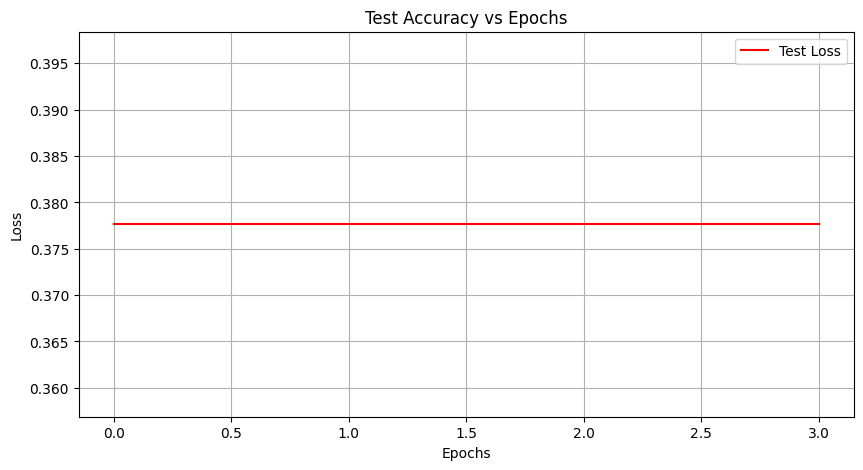

In [28]:
for epoch in range(num_epochs):
    model.train() # set to training mode
    epoch_loss = 0
    for batch_src, batch_labels in train_loader:
        optimizer.zero_grad()
        output = model(batch_src)
        loss = criterion(output, batch_labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(epoch_loss)

    # Evaluate performance
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for batch_src, batch_labels in test_loader:
            output = model(batch_src)

            _, predicted = torch.max(output, 1)
            correct_test += (predicted == batch_labels).sum().item()
            total_test += batch_labels.size(0)

    epoch_test_acc = correct_test / total_test
    test_accuracy.append(epoch_test_acc)
    print(f"Epoch {epoch + 1}/{num_epochs} \t Train Loss: {epoch_loss:.4f} \t Test Accuracy: {epoch_test_acc:.4f}")


plt.figure(figsize=(10, 5))
plt.plot(test_accuracy, label='Test Loss', color='red')
plt.title('Test Accuracy vs Epochs')
plt.xlabel('Epochs'); plt.ylabel('Loss')
plt.legend(); plt.grid()
plt.show()